In [47]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [48]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        dt: float = 1e-6,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        self.dt = dt
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self, h: torch.Tensor, x: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """
        h: [batch, 2] - [i_L, v_C]
        x: [batch, 1] - [v_a]
        """
        i_L = h[:, 0]
        v_C = h[:, 1]
        v_a = x[:, 0].clone()

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # --- DCM対応: 元のコードと同じロジック ---
        # スイッチOFF（va==0）かつ電流がゼロ以下の時、va = v_C（出力電圧）
        idx = (v_a == 0) & (i_L <= 0)
        v_a[idx] = v_C[idx]

        # 実効的なvaを保存（可視化用）
        v_a_eff = v_a.clone()
        # --------------------------------------------

        # オイラー法による状態更新（元のコードと同じ順序）
        # 1. インダクタ電流の更新
        i_L_next = i_L + (self.dt / L) * (v_a - v_C)
        i_L_next = torch.relu(i_L_next)  # 電流は負にならない（DCM考慮）

        # 2. コンデンサ電圧の更新（現在のi_Lを使用）
        v_C_next = v_C + (self.dt / C) * (i_L - v_C / R)

        return torch.stack([i_L_next, v_C_next], dim=1), v_a_eff

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
        }

# BuckConverterCell を使ってシミュレーションデータを作成


In [49]:
# 真値パラメータ（すべてのデータセットで共通）
L_true = 10e-6
C_true = 1000e-6
R_true = 3

# 固定のサンプリング周期を使用（最高周波数に合わせる）
base_fs = 30e3  # 基準となる最高周波数
samples_per_cycle = 100
dt = 1 / (base_fs * samples_per_cycle)  # 固定dt
n_samples = 20000  # サンプル数

# データ生成条件のリスト（入力電圧と参照電圧のみ変更）
conditions = [
    # (Vin, Vref)
    (28, 6),
    (12, 6),
    (15, 7),
    (10, 5),
    (14, 8),
    (11, 4),
    (13, 6),
    (12, 7),
    (12, 5),
    (16, 8),
    (9, 4.5),
    (13, 6.5),
    (11, 5.5),
]

datasets = []

for i, (Vin, Vref) in enumerate(conditions):
    print(f"データセット {i + 1}/{len(conditions)} を生成中: Vin={Vin}V, Vref={Vref}V")

    # 方形波生成（固定周波数20kHzでPWM）
    fs_pwm = 20e3  # PWMのスイッチング周波数
    Ts_pwm = 1 / fs_pwm
    t = np.arange(0, n_samples) * dt

    # PWM波形を生成
    vp = np.zeros(n_samples)
    for j in range(n_samples):
        phase = (t[j] % Ts_pwm) / Ts_pwm
        vp[j] = Vin if phase < (Vref / Vin) else 0

    # モデルを作成
    model = BuckConverterCell(dt=dt, L_init=L_true, C_init=C_true, R_init=R_true)

    va_list = []
    il_list = []
    vo_list = []

    # シミュレーション実行
    with torch.no_grad():
        h_current = torch.zeros(1, 2)  # [i_L=0, v_C=0]
        for j in range(len(vp)):
            va_input = torch.tensor([[vp[j]]], dtype=torch.float32)

            # 現在の状態を保存
            il_list.append(h_current[0, 0].item())  # i_L
            vo_list.append(h_current[0, 1].item())  # v_C (= v_o)

            # 次の状態と実効vaを計算
            h_current, va_eff = model(h_current, va_input)

            # 実効的なva（DCM対応済み）を保存
            va_list.append(va_eff[0].item())

    va = np.array(va_list)
    il = np.array(il_list)
    vo = np.array(vo_list)

    datasets.append(
        {
            "Vin": Vin,
            "Vref": Vref,
            "fs": fs_pwm,
            "t": t,
            "vp": vp,
            "va": va,
            "il": il,
            "vo": vo,
            "dt": dt,
        }
    )


# データセットを生成
print(f"\\n生成完了: {len(datasets)}個のデータセット")
print(
    f"真値パラメータ: L={L_true * 1e6:.1f}µH, C={C_true * 1e6:.1f}µF, R={R_true:.1f}Ω"
)
print(f"共通サンプリング周期: dt={dt * 1e6:.3f}µs")

データセット 1/13 を生成中: Vin=28V, Vref=6V
データセット 2/13 を生成中: Vin=12V, Vref=6V
データセット 3/13 を生成中: Vin=15V, Vref=7V
データセット 4/13 を生成中: Vin=10V, Vref=5V
データセット 5/13 を生成中: Vin=14V, Vref=8V
データセット 6/13 を生成中: Vin=11V, Vref=4V
データセット 7/13 を生成中: Vin=13V, Vref=6V
データセット 8/13 を生成中: Vin=12V, Vref=7V
データセット 9/13 を生成中: Vin=12V, Vref=5V
データセット 10/13 を生成中: Vin=16V, Vref=8V
データセット 11/13 を生成中: Vin=9V, Vref=4.5V
データセット 12/13 を生成中: Vin=13V, Vref=6.5V
データセット 13/13 を生成中: Vin=11V, Vref=5.5V
\n生成完了: 13個のデータセット
真値パラメータ: L=10.0µH, C=1000.0µF, R=3.0Ω
共通サンプリング周期: dt=0.333µs


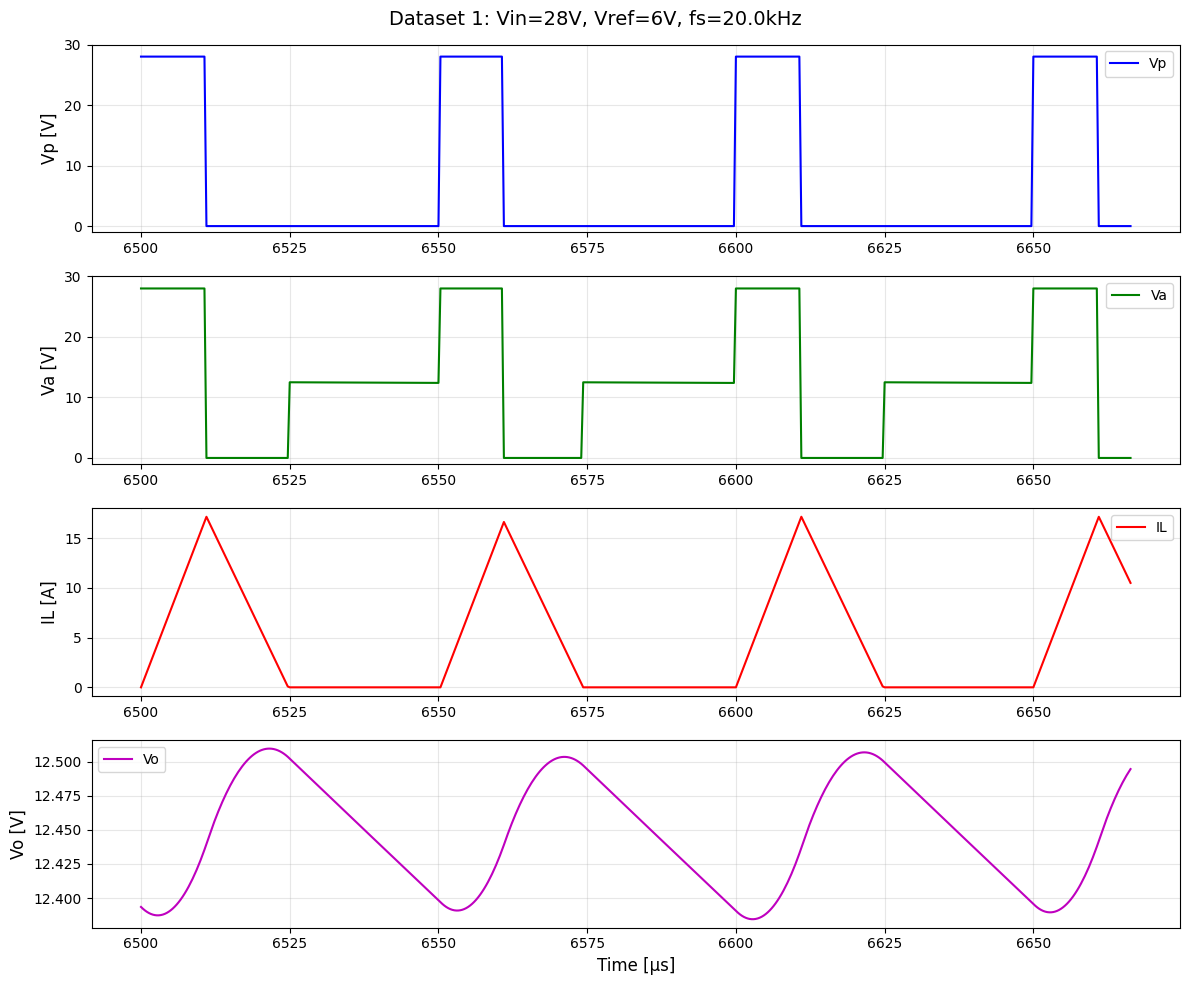

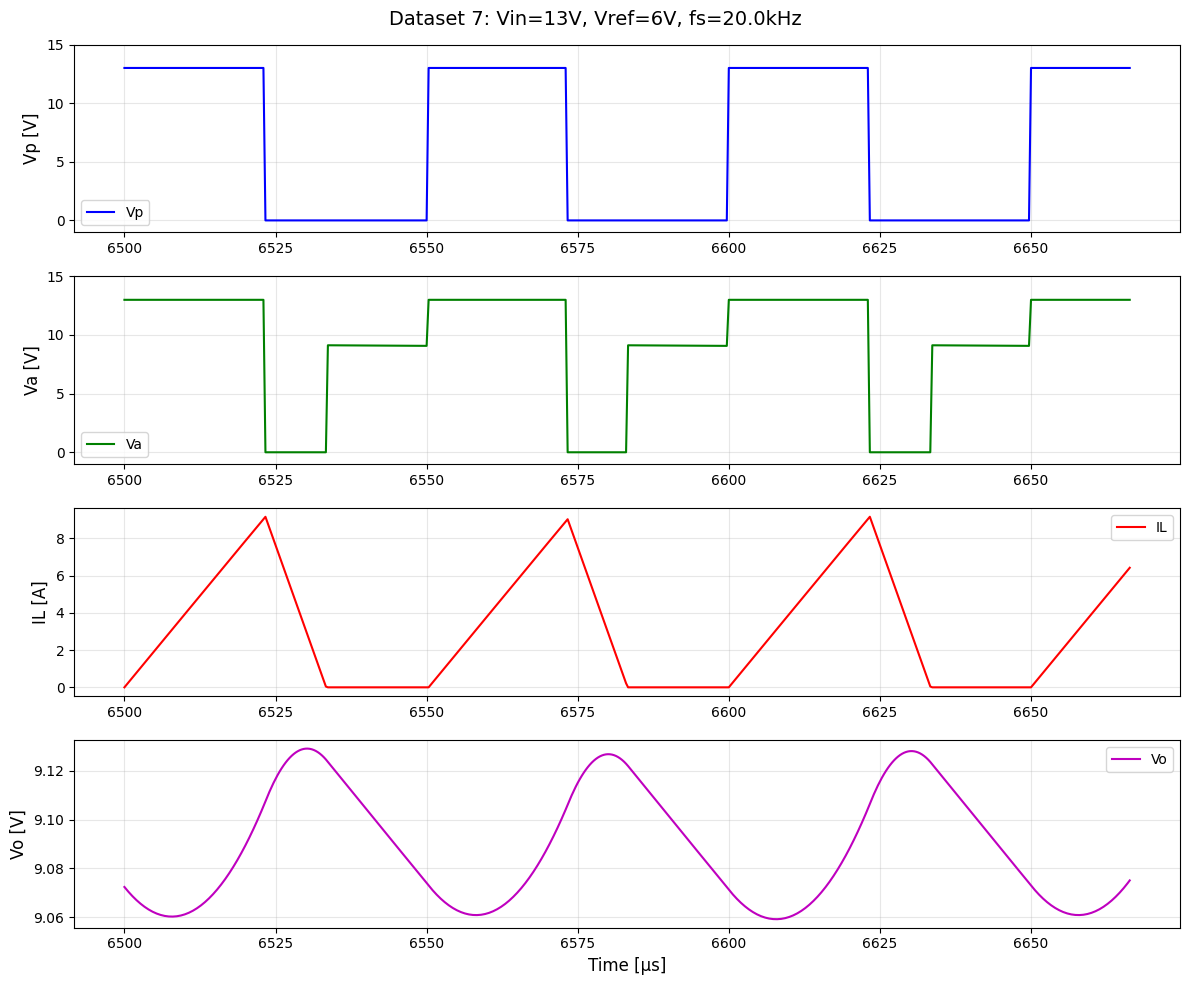

In [50]:
# 生成したデータセットのサンプルを可視化
plot_range = 500

# 最初と中間のデータセットを選んでプロット
for idx in [0, 6]:
    dataset = datasets[idx]
    t = dataset["t"]
    vp = dataset["vp"]
    va = dataset["va"]
    il = dataset["il"]
    vo = dataset["vo"]

    fig, axes = plt.subplots(4, 1, figsize=(12, 10))

    # タイトル
    fig.suptitle(
        f"Dataset {idx + 1}: Vin={dataset['Vin']}V, "
        f"Vref={dataset['Vref']}V, fs={dataset['fs'] / 1e3:.1f}kHz",
        fontsize=14,
    )

    # vp (PWM入力)
    axes[0].plot(
        t[-plot_range:] * 1e6, vp[-plot_range:], "b-", linewidth=1.5, label="Vp"
    )
    axes[0].set_ylabel("Vp [V]", fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(-1, dataset["Vin"] + 2)
    axes[0].legend()

    # va (実効電圧、DCM対応)
    axes[1].plot(
        t[-plot_range:] * 1e6,
        va[-plot_range:],
        "g-",
        linewidth=1.5,
        label="Va",
    )
    axes[1].set_ylabel("Va [V]", fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(-1, dataset["Vin"] + 2)
    axes[1].legend()

    # il (インダクタ電流)
    axes[2].plot(
        t[-plot_range:] * 1e6,
        il[-plot_range:],
        "r-",
        linewidth=1.5,
        label="IL",
    )
    axes[2].set_ylabel("IL [A]", fontsize=12)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    # vo (出力電圧)
    axes[3].plot(
        t[-plot_range:] * 1e6,
        vo[-plot_range:],
        "m-",
        linewidth=1.5,
        label="Vo",
    )
    axes[3].set_ylabel("Vo [V]", fontsize=12)
    axes[3].set_xlabel("Time [µs]", fontsize=12)
    axes[3].grid(True, alpha=0.3)
    axes[3].legend()

    plt.tight_layout()
    plt.show()

# シミュレーションデータを使って回路パラメータの推論


## 現状の主な問題点

1. エポックがかかりすぎる
   1. 先行研究では 75 だが、note3 では 3000 くらいかかった
   2. 学習率を各回路パラメータごとに変える
      1. 先行研究では学習率を回路パラメータごとに変えている
      2. note3 では全て同じ学習率でやった
      3. オーダーが違うのでそれにある程度合わせる
   3. 初期値の取り方
2. 学習データの種類が 1 パターンしかない
   1. 先行研究の方では 2 つの異なる学習データを使っている
3. 回路パラメータが負になってしまうパターンがあることがわかった
   1. 回路パラメータは本来、正の値しかありえないが、学習の過程で負の値になることがある
   2. 先行研究では Clamper と初期値を都合のいいように設定して負にならないようにしているが、初期値や clamp の範囲をいじると負になることがあった
   3. note3 では log と exp を使って正の値を保証している
      1. これはとりあえずおっけい
   4. 問題は、clamp の範囲をどこまでどのように設定すれば正しく学習が進むかわからない
   5. おそらく極端なデータを学習させるとバグる

## このノートブックで実装すること

1. 学習データを 2 つ用意し、学習させる
   1. 回路パラメータを変えずに入力電圧を変える
2. 回路パラメータごとに学習率を変える
3. 初期値をランダムに取ってみる
   1. He の初期化か、Glorot の初期化か...


## 複数データセットを使った学習

複数の条件（入力電圧、スイッチング周波数）でシミュレーションデータを生成し、それらを統合して学習を行います。これにより、より汎用的なパラメータ推定が可能になります。

In [51]:
# 複数データセットを使った学習

# 学習データの準備（複数データセットを結合）
def prepare_training_data(datasets, train_ratio=0.8):
    """
    複数のデータセットを学習用とテスト用に分割して準備
    すべてのデータセットは同じ長さである前提
    """
    all_va_list = []
    all_il_list = []
    all_vo_list = []

    for dataset in datasets:
        # 各データセットから必要な部分を取得
        va = dataset['va'][:-1]  # 最後の1要素を除く（次ステップ予測のため）
        il = dataset['il']
        vo = dataset['vo']

        all_va_list.append(va)
        all_il_list.append(il)
        all_vo_list.append(vo)

    # データセットを訓練用とテスト用に分割
    n_datasets = len(datasets)
    n_train = int(n_datasets * train_ratio)

    # 訓練データ
    train_va = np.concatenate(all_va_list[:n_train])
    train_il = np.concatenate(all_il_list[:n_train])
    train_vo = np.concatenate(all_vo_list[:n_train])

    # テストデータ（残り）
    test_va = all_va_list[n_train:]
    test_il = all_il_list[n_train:]
    test_vo = all_vo_list[n_train:]

    return (train_va, train_il, train_vo), (test_va, test_il, test_vo)

# データを準備
(train_va, train_il, train_vo), (test_va_list, test_il_list, test_vo_list) = prepare_training_data(datasets)

print(f"訓練データサイズ: va={train_va.shape}, il={train_il.shape}, vo={train_vo.shape}")
print(f"テストデータセット数: {len(test_va_list)}")

# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 5e-4  # インダクタンス用
lr_C = 1e-3  # キャパシタンス用
lr_R = 1e-2  # 抵抗用

epochs = 3000  # エポック数を減らす（複数データのため収束が早い）

# テンソルに変換
va_tensor = torch.tensor(train_va, dtype=torch.float32).unsqueeze(1)
iL_tensor = torch.tensor(train_il, dtype=torch.float32)
vo_tensor = torch.tensor(train_vo, dtype=torch.float32)

# モデルとオプティマイザの設定
model = BuckConverterCell(dt=common_dt, L_init=L_init, C_init=C_init, R_init=R_init)

# パラメータごとに異なる学習率を設定
optimizer = optim.Adam([
    {'params': [model.log_L], 'lr': lr_L},
    {'params': [model.log_C], 'lr': lr_C},
    {'params': [model.log_R], 'lr': lr_R}
])

loss_fn = nn.MSELoss()

loss_history = []
param_history = {"L": [], "C": [], "R": []}

# 学習データの準備
h_seq = torch.stack([iL_tensor[:-1], vo_tensor[:-1]], dim=1)
h_target = torch.stack([iL_tensor[1:], vo_tensor[1:]], dim=1)

print("\\n学習を開始します...")
print(f"初期パラメータ: L={L_init*1e6:.1f}µH, C={C_init*1e6:.1f}µF, R={R_init:.1f}Ω")
print(f"共通dt: {common_dt*1e6:.3f}µs")

# 学習ループ
for epoch in range(epochs):
    optimizer.zero_grad()
    h_pred, va_eff = model(h_seq, va_tensor)
    loss = loss_fn(h_pred, h_target)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])

    if epoch % 200 == 0:
        print(
            f"Epoch {epoch}: Loss={loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={R_true:.1f})"
        )

# 最終結果の表示
print("\\n=== 学習結果（複数データセット使用）===")
learned_params = model.get_params()
for key in ["L", "C", "R"]:
    true_val = {"L": L_true, "C": C_true, "R": R_true}[key]
    learned_val = learned_params[key]
    error = abs(learned_val - true_val) / true_val * 100

    if key in ["L", "C"]:
        unit = "H" if key == "L" else "F"
        print(
            f"{key}: True={true_val * 1e6:.1f}µ{unit}, "
            f"Learned={learned_val * 1e6:.1f}µ{unit}, "
            f"Error={error:.1f}%"
        )
    else:
        print(
            f"{key}: True={true_val:.1f}Ω, Learned={learned_val:.2f}Ω, "
            f"Error={error:.1f}%"
        )

訓練データサイズ: va=(199990,), il=(200000,), vo=(200000,)
テストデータセット数: 3


NameError: name 'common_dt' is not defined

In [ ]:
# テストデータでの推論と可視化

# テストデータセットの1つを選択して評価
test_idx = 0
test_dataset_idx = len(datasets) - len(test_va_list) + test_idx
test_dataset = datasets[test_dataset_idx]

print(f"テストデータセット: Vin={test_dataset['Vin']}V, Vref={test_dataset['Vref']}V, fs={test_dataset['fs']/1e3:.1f}kHz")

# テストデータの準備
test_va = torch.tensor(test_va_list[test_idx][:-1], dtype=torch.float32).unsqueeze(1)
test_il = torch.tensor(test_il_list[test_idx], dtype=torch.float32)
test_vo = torch.tensor(test_vo_list[test_idx], dtype=torch.float32)

# シミュレーション実行
with torch.no_grad():
    h_init = torch.stack([test_il[0], test_vo[0]], dim=0).unsqueeze(0)
    h_sim = [h_init]

    for t in range(1, len(test_va)):
        h_next, va_eff = model(h_sim[-1], test_va[t-1].unsqueeze(0))
        h_sim.append(h_next)

    h_sim = torch.cat(h_sim, dim=0)

il_sim = h_sim[:, 0].numpy()
vo_sim = h_sim[:, 1].numpy()

# 時間軸
time = np.arange(len(test_il)) * test_dataset['dt'] * 1e6  # μs単位

# プロット
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

# 損失関数の履歴
axes[0].semilogy(loss_history)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss (MSE)")
axes[0].grid(True, alpha=0.3)
axes[0].set_title(f"Training Loss (Multiple Datasets: {len(datasets)} sets)")

# インダクタ電流
axes[1].plot(time[:500], test_il_list[test_idx][:500], label="True i_L", linewidth=2)
axes[1].plot(time[:500], il_sim[:500], "--", label="Predicted i_L", linewidth=2)
axes[1].set_ylabel("Inductor Current [A]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_title(f"Test Dataset: Vin={test_dataset['Vin']}V, fs={test_dataset['fs']/1e3:.1f}kHz")

# キャパシタ電圧
axes[2].plot(time[:500], test_vo_list[test_idx][:500], label="True v_C", linewidth=2)
axes[2].plot(time[:500], vo_sim[:500], "--", label="Predicted v_C", linewidth=2)
axes[2].set_ylabel("Capacitor Voltage [V]")
axes[2].set_xlabel("Time [μs]")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# パラメータ推定の履歴
ax3_twin = axes[3].twinx()
ax3_twin2 = axes[3].twinx()
ax3_twin2.spines['right'].set_position(('outward', 60))

axes[3].plot(np.array(param_history["L"]) * 1e6, 'b-', label="L", linewidth=2)
ax3_twin.plot(np.array(param_history["C"]) * 1e6, 'r-', label="C", linewidth=2)
ax3_twin2.plot(param_history["R"], 'g-', label="R", linewidth=2)

# 真値を点線で表示
axes[3].axhline(y=L_true * 1e6, color='b', linestyle='--', alpha=0.5)
ax3_twin.axhline(y=C_true * 1e6, color='r', linestyle='--', alpha=0.5)
ax3_twin2.axhline(y=R_true, color='g', linestyle='--', alpha=0.5)

axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("L [μH]", color='b')
ax3_twin.set_ylabel("C [μF]", color='r')
ax3_twin2.set_ylabel("R [Ω]", color='g')
axes[3].tick_params(axis='y', labelcolor='b')
ax3_twin.tick_params(axis='y', labelcolor='r')
ax3_twin2.tick_params(axis='y', labelcolor='g')
axes[3].grid(True, alpha=0.3)
axes[3].set_title("Parameter Evolution During Training")

plt.tight_layout()
plt.show()

# 全テストデータセットでの評価
print("\\n=== 全テストデータセットでの評価 ===")
test_errors = []

for idx in range(len(test_va_list)):
    test_va = torch.tensor(test_va_list[idx][:-1], dtype=torch.float32).unsqueeze(1)
    test_il = torch.tensor(test_il_list[idx], dtype=torch.float32)
    test_vo = torch.tensor(test_vo_list[idx], dtype=torch.float32)

    with torch.no_grad():
        h_seq_test = torch.stack([test_il[:-1], test_vo[:-1]], dim=1)
        h_pred_test, _ = model(h_seq_test, test_va)
        h_target_test = torch.stack([test_il[1:], test_vo[1:]], dim=1)

        test_loss = loss_fn(h_pred_test, h_target_test).item()
        test_errors.append(test_loss)

        test_dataset = datasets[len(datasets) - len(test_va_list) + idx]
        print(f"Dataset {idx+1}: Loss={test_loss:.6e} (Vin={test_dataset['Vin']}V, fs={test_dataset['fs']/1e3:.1f}kHz)")

print(f"\\n平均テスト誤差: {np.mean(test_errors):.6e}")
print(f"最大テスト誤差: {np.max(test_errors):.6e}")
print(f"最小テスト誤差: {np.min(test_errors):.6e}")